## Prepare imports

In [3]:
import torch
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from models.vae_mnist import VanillaVAE, BaseModel
from metrics.metrics import get_mse_metrics
from metrics.accuracies import compute_mse_accuracies
from metrics.loss import compute_mse_loss_fn
from datasets.mnist import MnistDataModule, MnistDataModuleConfig
from layers.ect import EctLayer, EctConfig
from directions import generate_2d_directions

DEVICE = "cuda:0"
config = OmegaConf.load("./configs/config_vae_mnist.yaml")

## Load Models and Data

In [4]:
layer = EctLayer(
    EctConfig(
        num_thetas=config.layer.ect_size,
        bump_steps=config.layer.ect_size,
        normalized=True,
        device=DEVICE,
    ),
    v=generate_2d_directions(config.layer.ect_size, DEVICE),
)

dm = MnistDataModule(MnistDataModuleConfig(root="./data/mnistpointcloud"))


vae_model = VanillaVAE(in_channels=1, latent_dim=64,img_size=config.layer.ect_size)

# Load the VAE model

metrics = get_mse_metrics()

vae_litmodel = BaseModel.load_from_checkpoint(
    f"./trained_models/{config.model.save_name}",
    model=vae_model,
    training_accuracy=metrics[0],
    test_accuracy=metrics[1],
    validation_accuracy=metrics[2],
    accuracies_fn=compute_mse_accuracies,
    loss_fn=compute_mse_loss_fn,
    learning_rate=0.01,
    layer=layer,
).to(DEVICE)




## Generate an ECT and use VAE as autoencoder to recreate the ECT

In [5]:
data_loader = dm.val_dataloader()
for batch_idx, features in enumerate(data_loader):
    break

features.to(DEVICE)
ect = layer(features,features.batch).unsqueeze(1)


with torch.no_grad():
    decoded, theinput, z_mean, z_log_var = vae_litmodel.forward(ect)

# Undo the VAE transform
decoded = (decoded + 1 ) / 2

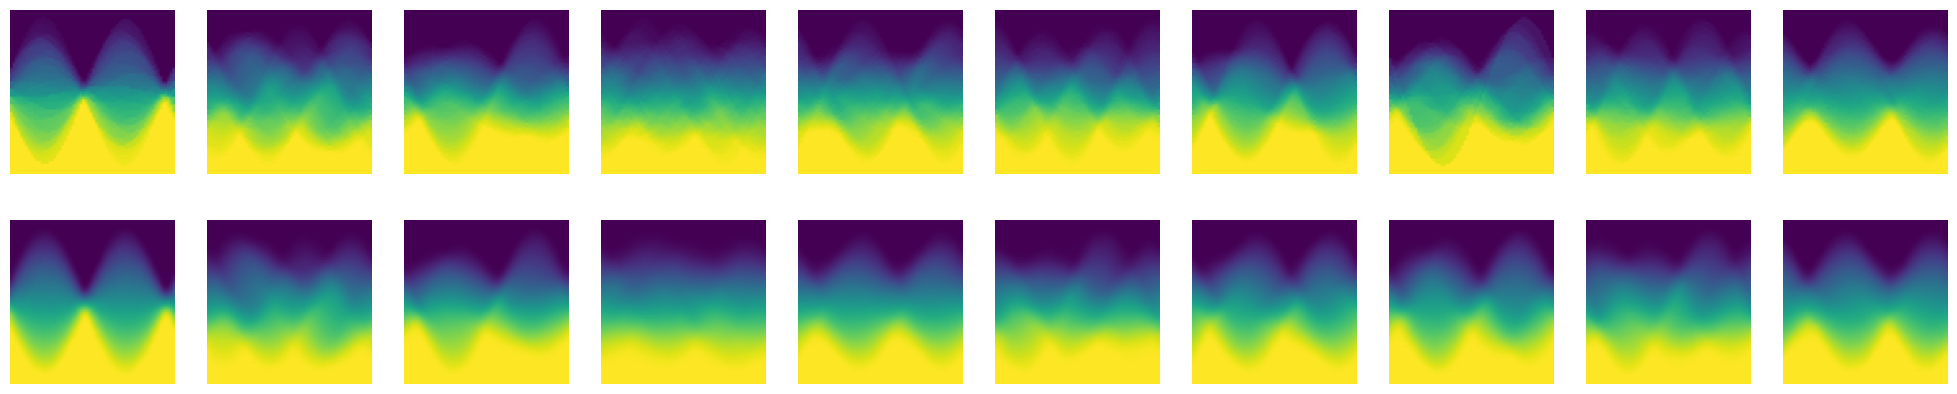

In [6]:
n_images = 10

fig, axes = plt.subplots(
    nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=(25,5)
)

for orig_img, recon_img,ax in zip(ect,decoded,axes.T):
    ax[0].imshow(orig_img.cpu().detach().squeeze().numpy())
    ax[0].axis("off")
    ax[1].imshow(recon_img.cpu().detach().squeeze().numpy())
    ax[1].axis("off")

## Sample from VAE and reconstruct points 

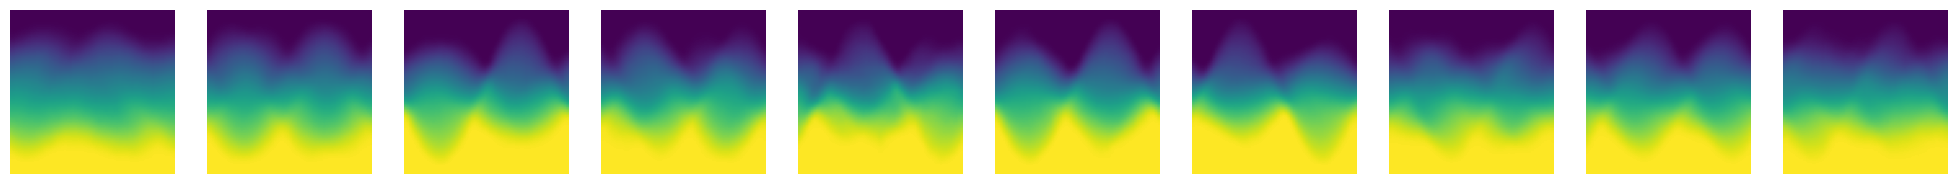

In [7]:
samples = vae_litmodel.model.sample(64, "cuda:0")

n_images = 10

fig, axes = plt.subplots(
    nrows=1, ncols=n_images, sharex=True, sharey=True, figsize=(25,5)
)

for sample, ax in zip(samples,axes.T):
    ax.imshow(sample.cpu().detach().squeeze().numpy())
    ax.axis("off")